# KE5105 - Building Electrical Consumption Forecasting

# Modelling 10 - Model Fine-tuning

## Summary of Findings
* 4x128 GRU, 2x32 Dense Model
	* L1 (5e-7), L2 (5e-7) Weight Regularisation
		* Minimum Validation Loss (normalised) = 1.875 (0.0176) @ epoch 306
	* L1 (1e-7), L2 (1e-7) Weight + L1 (1e-6), L2 (1e-6) Activity Regularisation
		* Minimum Validation Loss (normalised) = 2.743 (0.0258) @ epoch 245
	* L1 (1e-7), L2 (1e-7) Weight + L1 (5e-7), L2 (5e-7) Activity Regularisation
		* Minimum Validation Loss (normalised) = 2.476 (00.0233) @ epoch 257
	* L1 (1e-7), L2 (1e-7) Weight + L1 (1e-7), L2 (1e-7) Activity Regularisation
		* Minimum Validation Loss (normalised) = 1.924 (0.0181) @ epoch 244
	* L1 (1e-7), L2 (1e-7) Weight + L1 (1e-7) Activity Regularisation
		* Minimum Validation Loss (normalised) = 1.955 (0.0182) @ epoch 277

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5105/ETL/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras import layers
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.regularizers import l1,l2, l1_l2
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [5]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [6]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [7]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [8]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [9]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [10]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

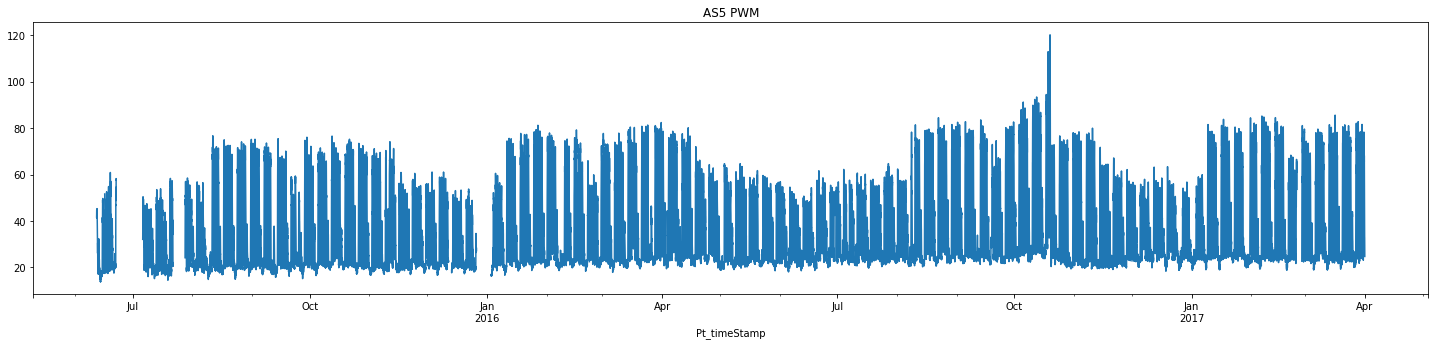

In [11]:
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [12]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [13]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [14]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

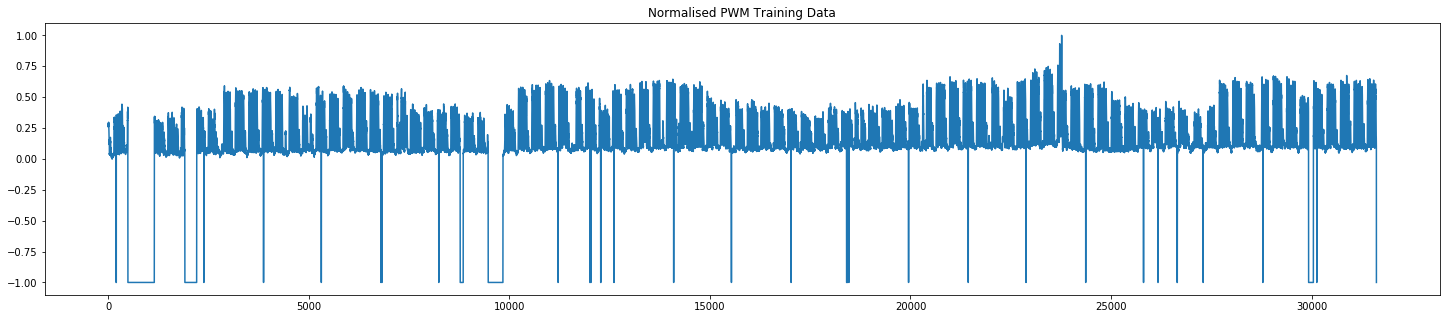

In [15]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

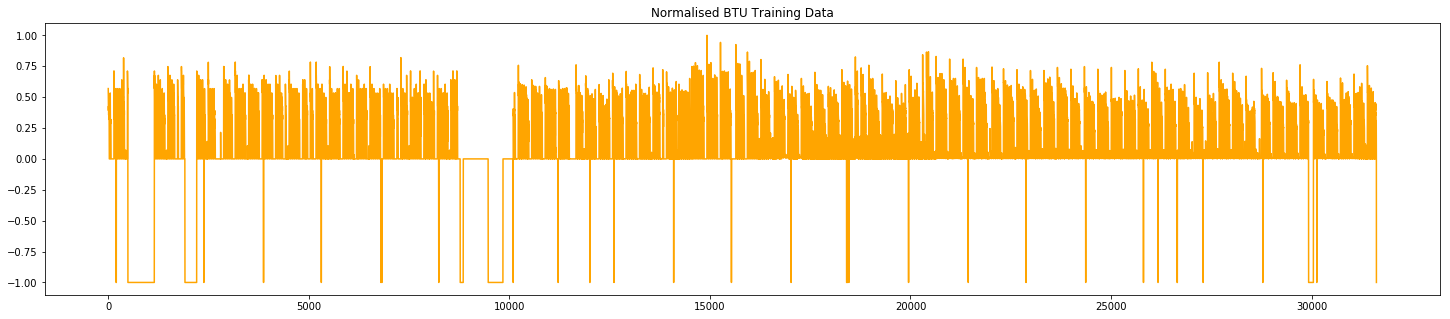

In [16]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Split a validation set out from the train set

In [17]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [18]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## 4x128 GRU, 2x32 Dense Model with L1 (5e-7), L2 (5e-7) Weight Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(5e-7, 5e-7), recurrent_regularizer=l1_l2(5e-7, 5e-7), bias_regularizer=l1_l2(5e-7, 5e-7),
                          return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(5e-7, 5e-7), recurrent_regularizer=l1_l2(5e-7, 5e-7), bias_regularizer=l1_l2(5e-7, 5e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(5e-7, 5e-7), recurrent_regularizer=l1_l2(5e-7, 5e-7), bias_regularizer=l1_l2(5e-7, 5e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(5e-7, 5e-7), recurrent_regularizer=l1_l2(5e-7, 5e-7), bias_regularizer=l1_l2(5e-7, 5e-7)))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-5e-7-epch200-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-5e-7-epch200.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [23]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=200,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-01 13:13:13.202457
Epoch 1/200
 - 15s - loss: 0.0162 - mean_absolute_percentage_error: 10.4311 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.6150
Epoch 2/200
 - 12s - loss: 0.0161 - mean_absolute_percentage_error: 10.3860 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.6804
Epoch 3/200
 - 13s - loss: 0.0161 - mean_absolute_percentage_error: 10.3452 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.8617
Epoch 4/200
 - 13s - loss: 0.0162 - mean_absolute_percentage_error: 10.3848 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.7660
Epoch 5/200
 - 13s - loss: 0.0161 - mean_absolute_percentage_error: 10.1795 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 8.2407
Epoch 6/200
 - 13s - loss: 0.0162 - mean_absolute_percentage_error: 10.4226 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 8.5825
Epoch 7/200
 - 13s - loss: 0.0160 - mean_absolute_percentage_error: 10.2851 - val_loss: 0.0198 - val_mean_absol

 - 13s - loss: 0.0152 - mean_absolute_percentage_error: 9.5860 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 8.7472
Epoch 60/200
 - 13s - loss: 0.0153 - mean_absolute_percentage_error: 9.6593 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 9.9654
Epoch 61/200
 - 13s - loss: 0.0152 - mean_absolute_percentage_error: 9.6638 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 8.1877
Epoch 62/200
 - 13s - loss: 0.0151 - mean_absolute_percentage_error: 9.6511 - val_loss: 0.0178 - val_mean_absolute_percentage_error: 8.1320
Epoch 63/200
 - 13s - loss: 0.0152 - mean_absolute_percentage_error: 9.7557 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.2707
Epoch 64/200
 - 13s - loss: 0.0152 - mean_absolute_percentage_error: 9.6195 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 8.2044
Epoch 65/200
 - 13s - loss: 0.0152 - mean_absolute_percentage_error: 9.6488 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 8.2040
Epoch 66/200
 - 13s - loss: 0.015

Epoch 118/200
 - 13s - loss: 0.0145 - mean_absolute_percentage_error: 9.1577 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 8.7543
Epoch 119/200
 - 13s - loss: 0.0146 - mean_absolute_percentage_error: 9.1054 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.5185
Epoch 120/200
 - 14s - loss: 0.0146 - mean_absolute_percentage_error: 9.3266 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.0062
Epoch 121/200
 - 13s - loss: 0.0146 - mean_absolute_percentage_error: 9.3007 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.0776
Epoch 122/200
 - 13s - loss: 0.0146 - mean_absolute_percentage_error: 9.3477 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.6287
Epoch 123/200
 - 13s - loss: 0.0146 - mean_absolute_percentage_error: 9.2103 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.9287
Epoch 124/200
 - 13s - loss: 0.0146 - mean_absolute_percentage_error: 9.1800 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.3721
Epoch 125/200

Epoch 177/200
 - 13s - loss: 0.0143 - mean_absolute_percentage_error: 9.0171 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.2829
Epoch 178/200
 - 13s - loss: 0.0141 - mean_absolute_percentage_error: 8.8704 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.2758
Epoch 179/200
 - 13s - loss: 0.0142 - mean_absolute_percentage_error: 8.8305 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.4889
Epoch 180/200
 - 13s - loss: 0.0142 - mean_absolute_percentage_error: 8.9434 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 8.5969
Epoch 181/200
 - 12s - loss: 0.0142 - mean_absolute_percentage_error: 9.0722 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 8.6218
Epoch 182/200
 - 12s - loss: 0.0141 - mean_absolute_percentage_error: 8.7971 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 8.5370
Epoch 183/200
 - 13s - loss: 0.0142 - mean_absolute_percentage_error: 8.9924 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 8.1100
Epoch 184/200

In [24]:
# histories = [] # for first training session
histories.append(history.history)

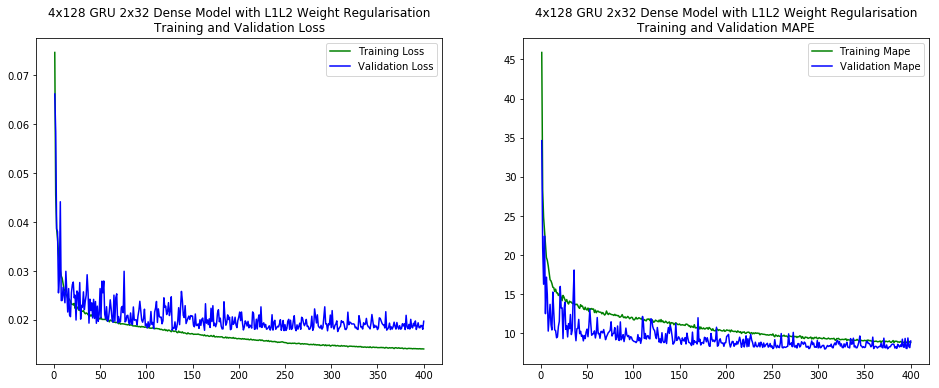

In [25]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.ylim((0.01, 0.04))
plt.title('4x128 GRU 2x32 Dense Model with L1L2 Weight Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with L1L2 Weight Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [26]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.014062
Validation min loss = 0.017626
Validation min epoch = 306


In [27]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.495887
Validation MAE = 1.875079


In [28]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [29]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

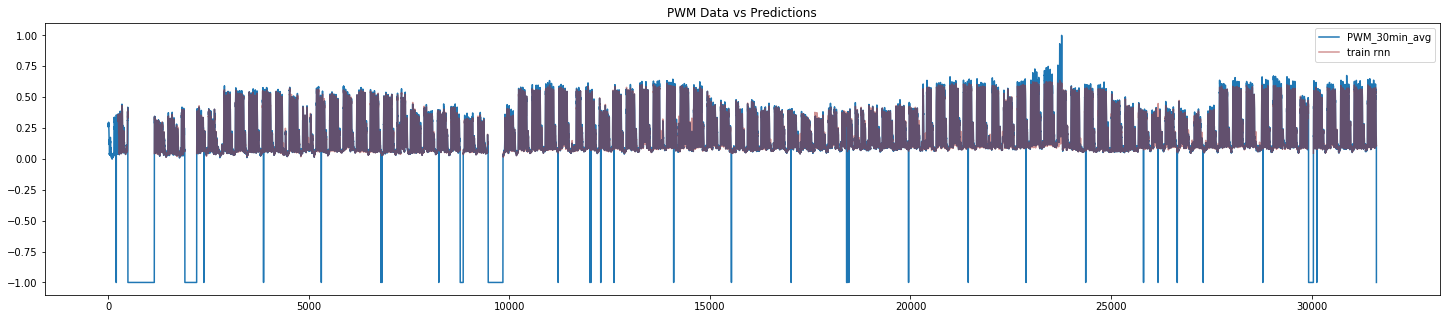

In [30]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

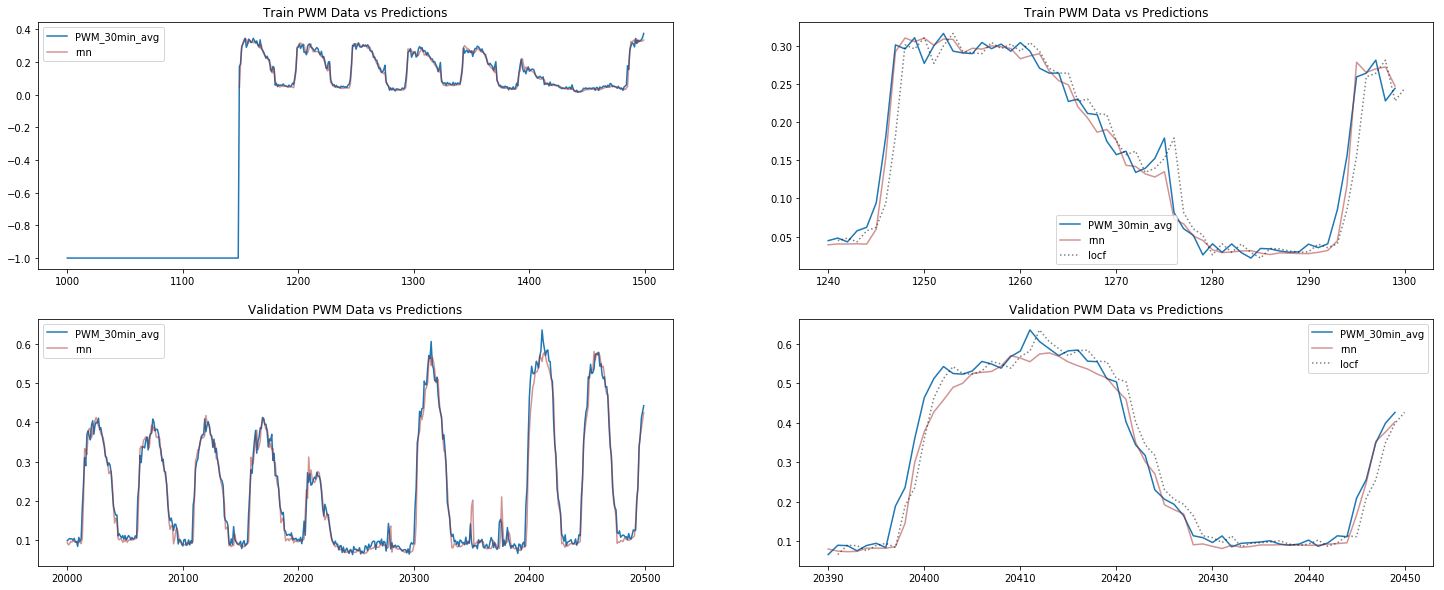

In [31]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [32]:
model.save('base-4x128gru-2x32dense-wgtl1l2-5e-7.h5')

In [33]:
with open('base-4x128gru-2x32dense-wgtl1l2-5e-7-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with L1 (1e-7), L2 (1e-7) Weight + L1 (1e-6), L2 (1e-6) Activity Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-6, 1e-6),
                          return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-6, 1e-6),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-6, 1e-6),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),  activity_regularizer=l1_l2(1e-6, 1e-6)))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-6-histories-epch200.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-6-epch200.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [22]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=400,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-04 20:04:18.239181

Training Duration = 1:35:30.152314


In [23]:
# histories = []  # for first training session
histories.append(history.history)

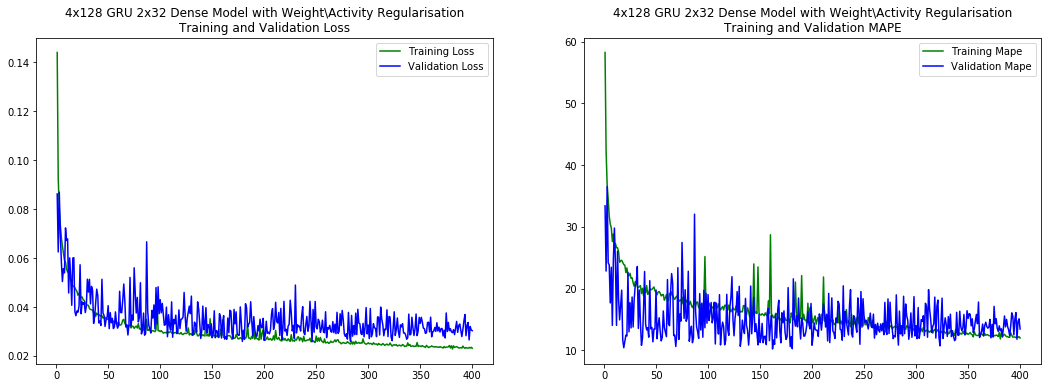

In [24]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.xlim((100, 350))
# plt.ylim((0.02, 0.06))
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [25]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.022842
Validation min loss = 0.025783
Validation min epoch = 245


In [26]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.429906
Validation MAE = 2.742768


In [27]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [28]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

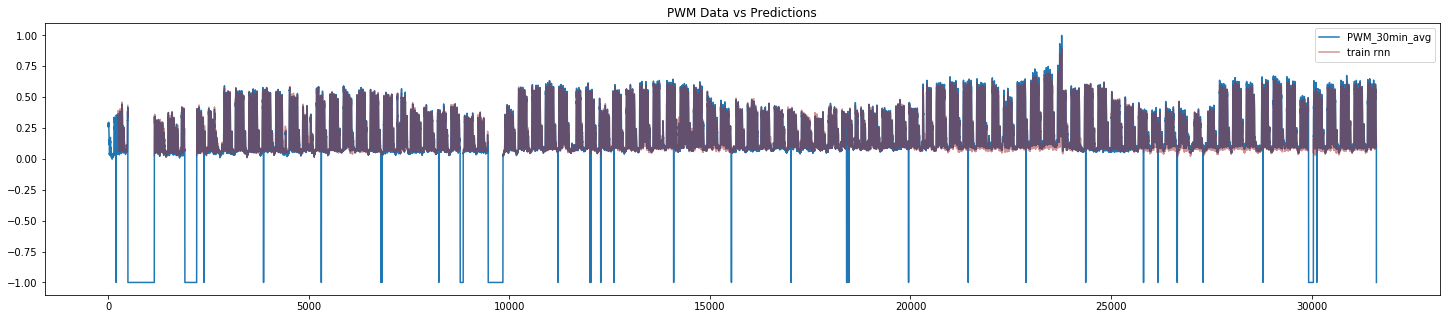

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

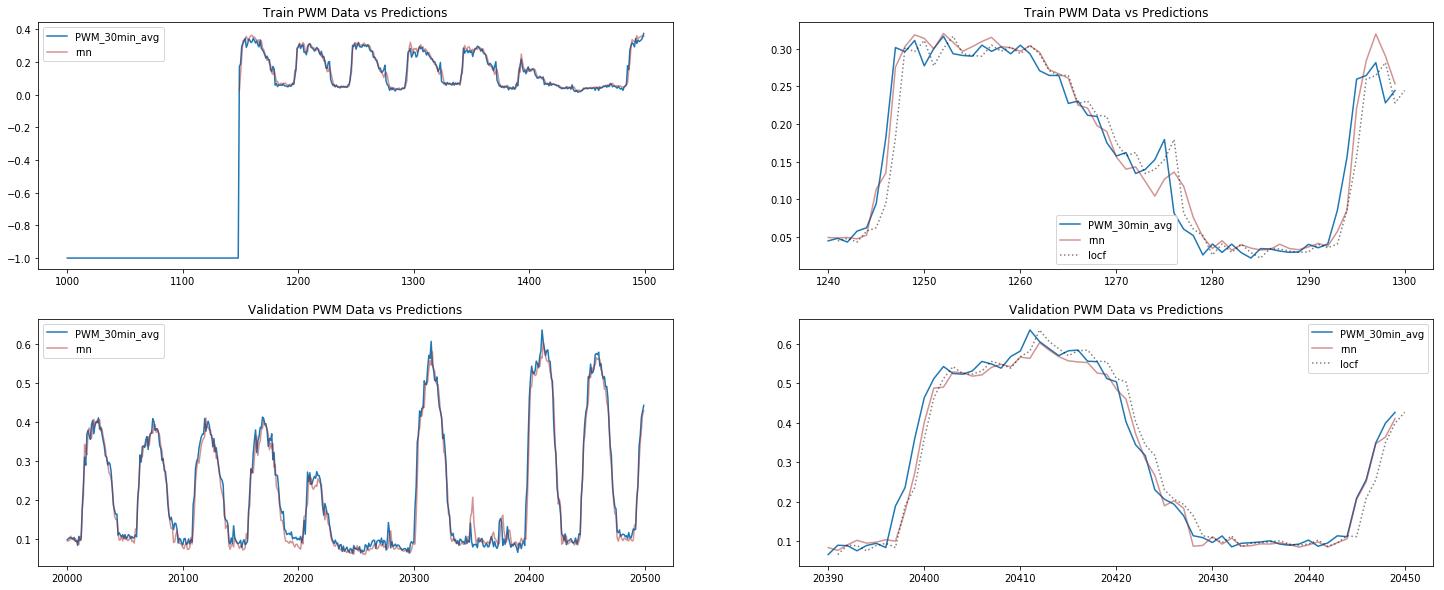

In [30]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [31]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-6.h5')

In [32]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-6-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with L1 (1e-7), L2 (1e-7) Weight + L1 (5e-7), L2 (5e-7) Activity Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(5e-7, 5e-7),
                          return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(5e-7, 5e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(5e-7, 5e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),  activity_regularizer=l1_l2(5e-7, 5e-7)))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-5e-7-histories-epch200.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-5e-7-epch200.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [22]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=400,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-04 21:59:03.245949
Epoch 1/400
 - 16s - loss: 0.1156 - mean_absolute_percentage_error: 54.3851 - val_loss: 0.0841 - val_mean_absolute_percentage_error: 20.9643
Epoch 2/400
 - 14s - loss: 0.0763 - mean_absolute_percentage_error: 36.9113 - val_loss: 0.0785 - val_mean_absolute_percentage_error: 29.0578
Epoch 3/400
 - 14s - loss: 0.0656 - mean_absolute_percentage_error: 32.3830 - val_loss: 0.0634 - val_mean_absolute_percentage_error: 22.1259
Epoch 4/400
 - 14s - loss: 0.0599 - mean_absolute_percentage_error: 29.1638 - val_loss: 0.0642 - val_mean_absolute_percentage_error: 27.4468
Epoch 5/400
 - 14s - loss: 0.0569 - mean_absolute_percentage_error: 28.8037 - val_loss: 0.0638 - val_mean_absolute_percentage_error: 26.7721
Epoch 6/400
 - 14s - loss: 0.0528 - mean_absolute_percentage_error: 27.3309 - val_loss: 0.0439 - val_mean_absolute_percentage_error: 13.6155
Epoch 7/400
 - 14s - loss: 0.0520 - mean_absolute_percentage_error: 26.7466 - val_loss: 0.0621 - val_mean

Epoch 59/400
 - 14s - loss: 0.0291 - mean_absolute_percentage_error: 15.7325 - val_loss: 0.0417 - val_mean_absolute_percentage_error: 16.5200
Epoch 60/400
 - 14s - loss: 0.0309 - mean_absolute_percentage_error: 16.4638 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 11.0875
Epoch 61/400
 - 14s - loss: 0.0288 - mean_absolute_percentage_error: 15.9081 - val_loss: 0.0409 - val_mean_absolute_percentage_error: 14.0902
Epoch 62/400
 - 14s - loss: 0.0293 - mean_absolute_percentage_error: 16.4675 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 14.7086
Epoch 63/400
 - 14s - loss: 0.0290 - mean_absolute_percentage_error: 16.4073 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 10.4163
Epoch 64/400
 - 14s - loss: 0.0286 - mean_absolute_percentage_error: 16.0844 - val_loss: 0.0446 - val_mean_absolute_percentage_error: 19.0831
Epoch 65/400
 - 14s - loss: 0.0285 - mean_absolute_percentage_error: 15.9588 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 15.7234
Epoch 

Epoch 117/400
 - 14s - loss: 0.0258 - mean_absolute_percentage_error: 14.6438 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 19.6316
Epoch 118/400
 - 14s - loss: 0.0259 - mean_absolute_percentage_error: 14.8162 - val_loss: 0.0388 - val_mean_absolute_percentage_error: 18.3737
Epoch 119/400
 - 14s - loss: 0.0259 - mean_absolute_percentage_error: 15.0304 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 10.2359
Epoch 120/400
 - 14s - loss: 0.0262 - mean_absolute_percentage_error: 15.4765 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 11.6317
Epoch 121/400
 - 14s - loss: 0.0255 - mean_absolute_percentage_error: 14.2509 - val_loss: 0.0347 - val_mean_absolute_percentage_error: 17.4622
Epoch 122/400
 - 14s - loss: 0.0261 - mean_absolute_percentage_error: 15.2083 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 9.8766
Epoch 123/400
 - 14s - loss: 0.0253 - mean_absolute_percentage_error: 14.2650 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 16.8532


Epoch 175/400
 - 14s - loss: 0.0242 - mean_absolute_percentage_error: 13.8874 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 9.8889
Epoch 176/400
 - 14s - loss: 0.0242 - mean_absolute_percentage_error: 14.0126 - val_loss: 0.0300 - val_mean_absolute_percentage_error: 13.8602
Epoch 177/400
 - 14s - loss: 0.0246 - mean_absolute_percentage_error: 14.2990 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 9.8034
Epoch 178/400
 - 14s - loss: 0.0241 - mean_absolute_percentage_error: 14.1646 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 14.8795
Epoch 179/400
 - 14s - loss: 0.0241 - mean_absolute_percentage_error: 14.1006 - val_loss: 0.0378 - val_mean_absolute_percentage_error: 18.4332
Epoch 180/400
 - 14s - loss: 0.0242 - mean_absolute_percentage_error: 14.1666 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 10.1654
Epoch 181/400
 - 14s - loss: 0.0244 - mean_absolute_percentage_error: 14.2938 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 13.6024
E

Epoch 233/400
 - 14s - loss: 0.0230 - mean_absolute_percentage_error: 13.2255 - val_loss: 0.0323 - val_mean_absolute_percentage_error: 14.2558
Epoch 234/400
 - 14s - loss: 0.0238 - mean_absolute_percentage_error: 13.9437 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 11.7852
Epoch 235/400
 - 14s - loss: 0.0229 - mean_absolute_percentage_error: 13.4535 - val_loss: 0.0367 - val_mean_absolute_percentage_error: 19.7673
Epoch 236/400
 - 14s - loss: 0.0233 - mean_absolute_percentage_error: 13.8066 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 13.1537
Epoch 237/400
 - 14s - loss: 0.0232 - mean_absolute_percentage_error: 13.6770 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 15.1636
Epoch 238/400
 - 14s - loss: 0.0227 - mean_absolute_percentage_error: 13.3305 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 11.5540
Epoch 239/400
 - 14s - loss: 0.0228 - mean_absolute_percentage_error: 13.2981 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 11.3841

Epoch 291/400
 - 14s - loss: 0.0221 - mean_absolute_percentage_error: 12.6992 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 11.9489
Epoch 292/400
 - 14s - loss: 0.0225 - mean_absolute_percentage_error: 13.0010 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 16.3601
Epoch 293/400
 - 14s - loss: 0.0220 - mean_absolute_percentage_error: 12.6790 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 13.3147
Epoch 294/400
 - 14s - loss: 0.0220 - mean_absolute_percentage_error: 12.6609 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 14.3125
Epoch 295/400
 - 14s - loss: 0.0218 - mean_absolute_percentage_error: 12.5811 - val_loss: 0.0300 - val_mean_absolute_percentage_error: 14.2468
Epoch 296/400
 - 14s - loss: 0.0287 - mean_absolute_percentage_error: 18.5209 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 15.7796
Epoch 297/400
 - 14s - loss: 0.0218 - mean_absolute_percentage_error: 12.5314 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 13.9303

Epoch 349/400
 - 14s - loss: 0.0212 - mean_absolute_percentage_error: 12.3100 - val_loss: 0.0332 - val_mean_absolute_percentage_error: 15.6816
Epoch 350/400
 - 14s - loss: 0.0209 - mean_absolute_percentage_error: 11.8080 - val_loss: 0.0341 - val_mean_absolute_percentage_error: 16.5055
Epoch 351/400
 - 14s - loss: 0.0211 - mean_absolute_percentage_error: 12.0670 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 12.3332
Epoch 352/400
 - 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.0897 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 14.2062
Epoch 353/400
 - 14s - loss: 0.0211 - mean_absolute_percentage_error: 11.9575 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 14.3810
Epoch 354/400
 - 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.1912 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 14.5671
Epoch 355/400
 - 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.0671 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 13.0384

In [23]:
# histories = []  ## if first training session
histories.append(history.history)

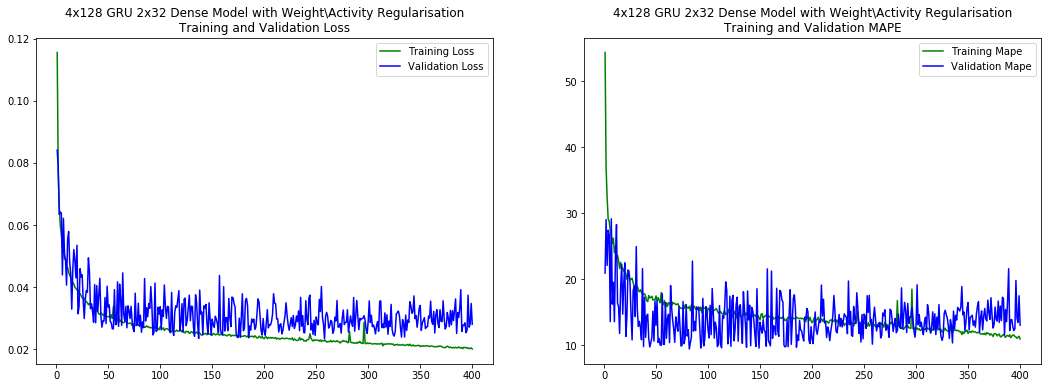

In [24]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.xlim((100, 350))
# plt.ylim((0.02, 0.06))
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [25]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.020066
Validation min loss = 0.023274
Validation min epoch = 257


In [26]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.134601
Validation MAE = 2.475910


In [27]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [28]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

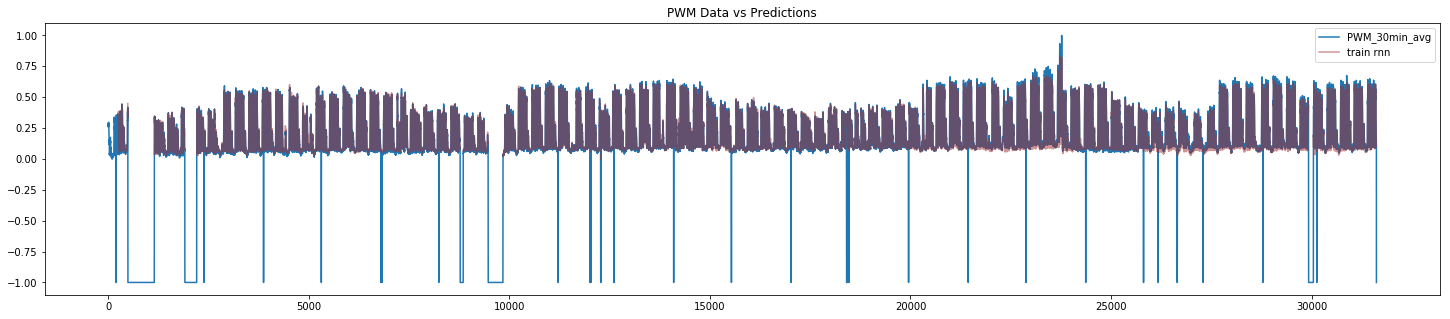

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

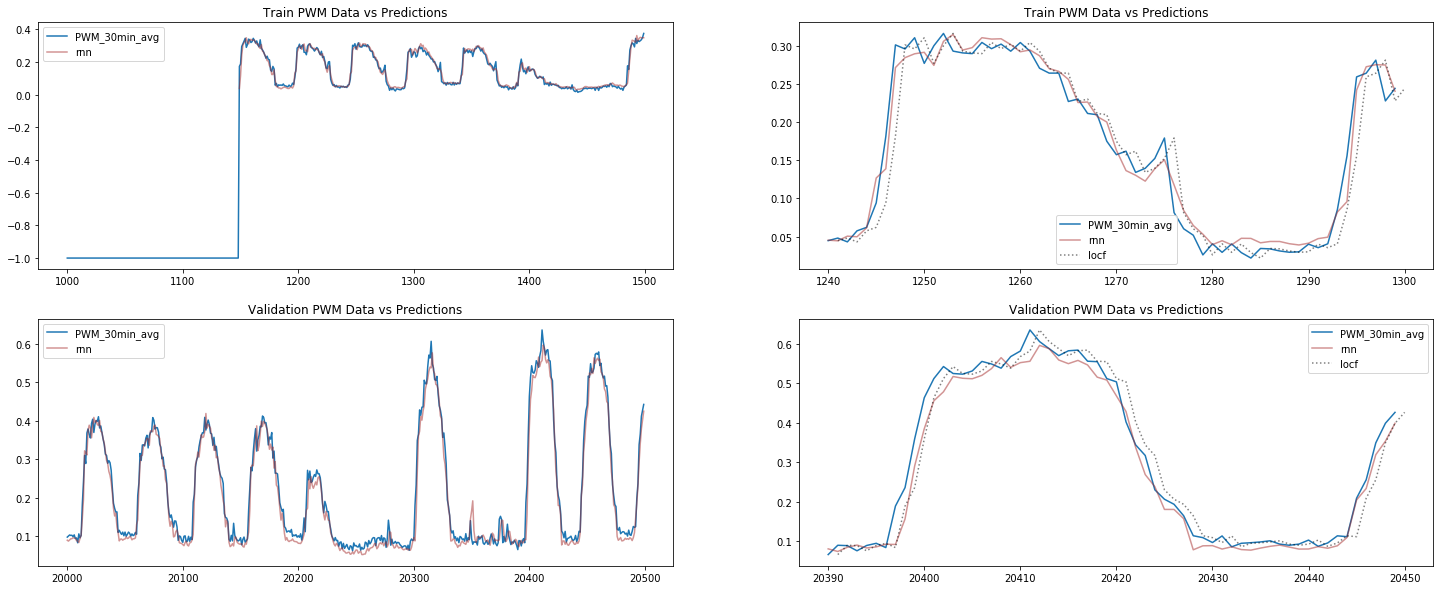

In [30]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [31]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-5e-7.h5')

In [32]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-5e-7-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with L1 (1e-7), L2 (1e-7) Weight + L1 (1e-7), L2 (1e-7) Activity Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-7, 1e-7),
                          return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-7, 1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-7, 1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),  activity_regularizer=l1_l2(1e-7, 1e-7)))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=400,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-05 21:24:16.933420

Training Duration = 1:34:46.138536


In [23]:
# histories = []  ## if first training session
histories.append(history.history)

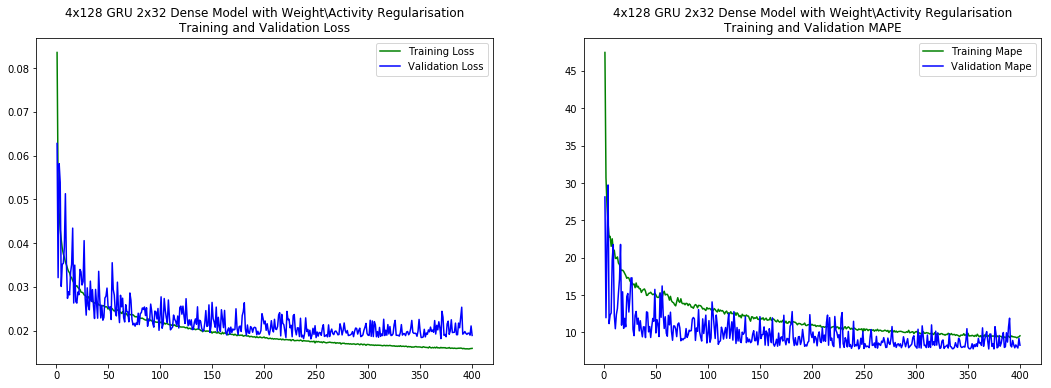

In [24]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.xlim((100, 350))
# plt.ylim((0.02, 0.06))
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [25]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.015781
Validation min loss = 0.018089
Validation min epoch = 244


In [26]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.678781
Validation MAE = 1.924339


In [27]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [28]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

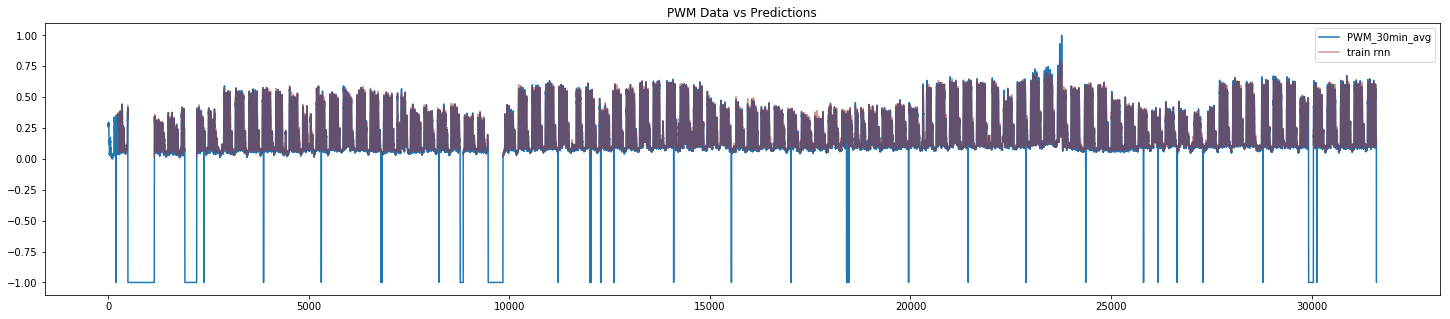

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

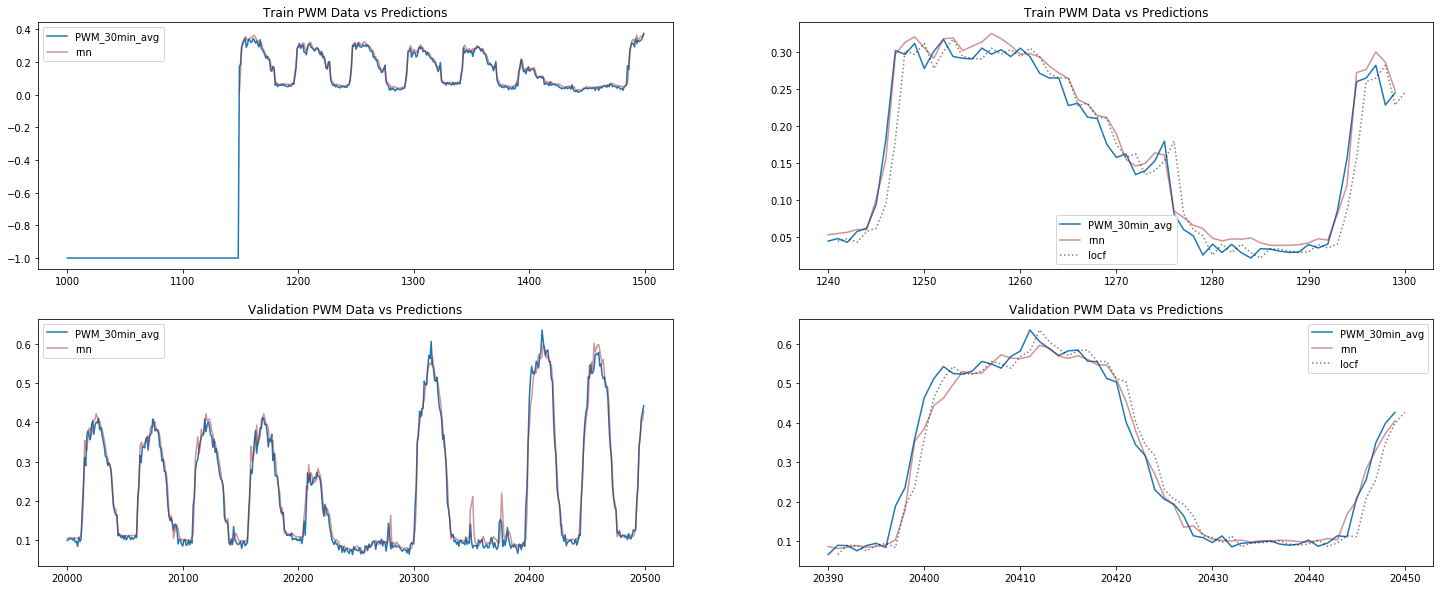

In [30]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [31]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-7.h5')

In [32]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-7-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with L1 (1e-7), L2 (1e-7) Weight + L1 (1e-7) Activity Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
callbacks_list = [
    ModelCheckpoint(
        # filepath='base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.{epoch:02d}-{val_loss:.2f}.h5',
        filepath='base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.best.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [21]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1(1e-7),
                          return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1(1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1(1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),  activity_regularizer=l1(1e-7)))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [22]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# # Temporary - to remove after training is completed
# # Load previous history
# with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout-histories.pkl'), 'rb') as infile:
#     histories = pickle.load(infile)
# # Load previous model
# from keras.models import load_model
# model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout.h5'))
# model.summary()

In [23]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=400,
                              callbacks=callbacks_list,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-07 10:10:07.737654

Training Duration = 1:30:50.152123


In [24]:
# histories = [] # for first training session
histories.append(history.history)

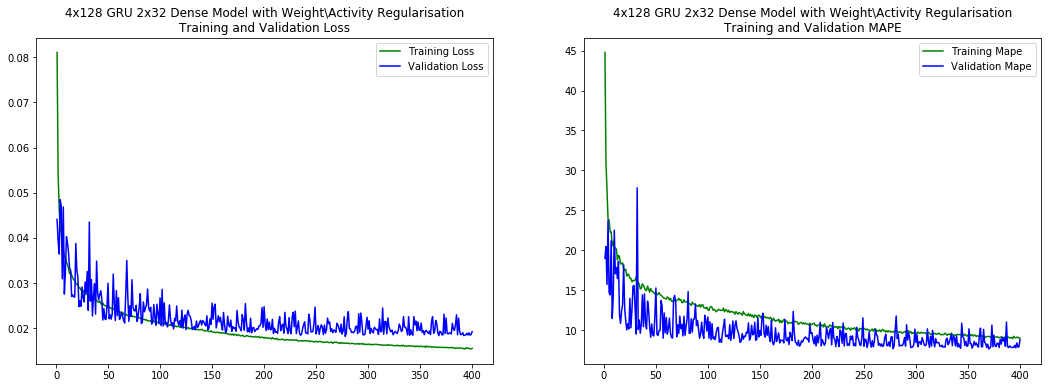

In [25]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.xlim((100, 350))
# plt.ylim((0.02, 0.06))
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [26]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.015407
Validation min loss = 0.018187
Validation min epoch = 277


In [27]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.639040
Validation MAE = 1.954555


In [28]:
# Load best model
best_model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.best.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [29]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [30]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

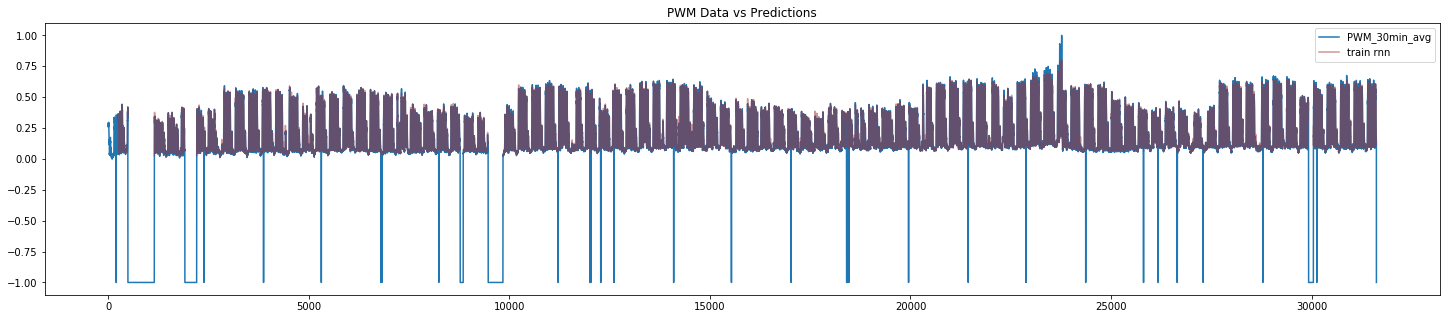

In [31]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

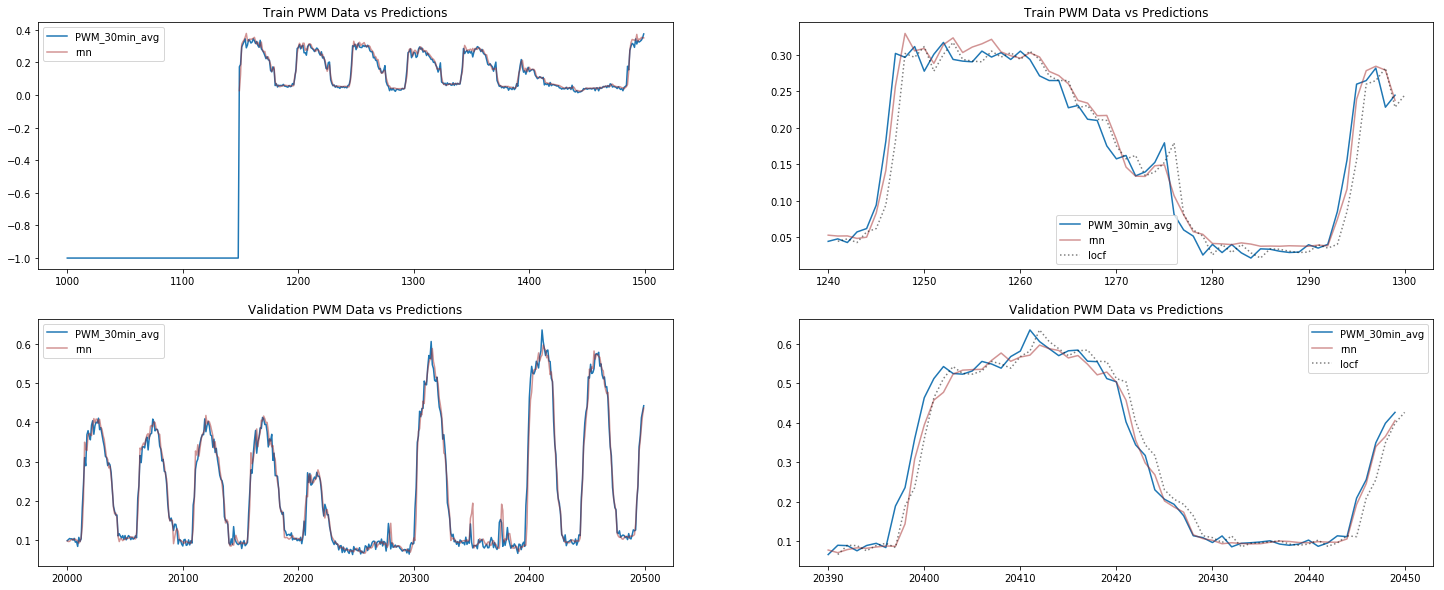

In [33]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [34]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7-histories-epch400.h5')

In [35]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7-histories-epch400.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)